# Preparing a General Body

## Overview

### Questions

* How do I prepare an arbitrary rigid body for use in HOOMD-blue?

### Objectives

* Define a rigid body with an arbitrary inertia tensor.
* Diagonalize the moment of inertia.
* Reorient the constituent particles in the diagonal body coordinates.

## Boilerplate Code

In [1]:
import math

import numpy

The `render_rigid_body` function in the next (hidden) cell will render the rigid body using 
**fresnel**. Find the source in the [hoomd-examples](https://github.com/glotzerlab/hoomd-examples) repository.

In [2]:
import os
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render_rigid_body(pos_body, radius_constituent=1):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )

    L = 3 * numpy.max(numpy.linalg.norm(pos_body, axis=1))
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(pos_body), radius=radius_constituent
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([93 / 255, 210 / 255, 252 / 255]), roughness=0.5
    )
    geometry.position[:] = pos_body
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

## Diagonalized Bodies:

HOOMD-blue assumes bodies are provided in a coordinate system where the moment of inertia tensor is
diagonal.

Given a body with arbitrarily placed constituent particles, you can follow this procedure to prepare
the body for use in HOOMD.

* Step 1: Get the inertia tensor of your rigid body (non-diagonalized).
* Step 2: Solve for the orientation of the body that diagonalizes the moment of inertia tensor.
* Step 3: Reorient the rigid body so that the rigid body inertia tensor is diagonalized in global coordinates.
* Step 4: Define the moments of inertia using the new diagonalized moments of inertia.

The remainder of this tutorial section demonstrates these steps for this body:

In [3]:
general_positions = numpy.array(
    [[0.5, 0.5, 0], [-0.5, -0.5, 0], [-1, 1, 0], [1, -1, 0]]
)
particle_mass = 1
particle_radius = 1

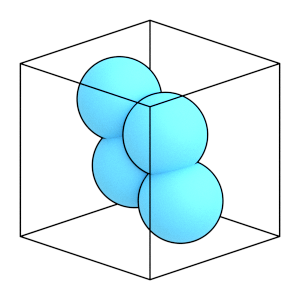

In [4]:
render_rigid_body(general_positions)

## Step 1: Compute the Inertia Tensor

HOOMD-blue makes no assumptions about the distribution of mass in your body. For example, you can
compute the moment of inertia assuming that each constituent particle is a uniform density ball.
The moment of inertia of a single ball computed about the center of the ball is:

In [5]:
I_ref = numpy.array(
    [
        [2 / 5 * particle_mass * particle_radius**2, 0, 0],
        [0, 2 / 5 * particle_mass * particle_radius**2, 0],
        [0, 0, 2 / 5 * particle_mass * particle_radius**2],
    ]
)
I_ref

array([[0.4, 0. , 0. ],
       [0. , 0.4, 0. ],
       [0. , 0. , 0.4]])

Using the [parallel axis theorem](https://en.wikipedia.org/wiki/Moment_of_inertia#Inertia_tensor_of_translation),
compute the moment of inertia tensor for the general body as a sum of constituent particle inertia
tensors: $I = I_{ref} + m[(D\cdot D)E_3 - D\otimes D]$

$I_{ref}$ is the reference moment of inertia, m is the mass, D is the displacement (i.e. the
position of the constituent particle in body coordinates) and $E_3$ is the identity matrix.

In [6]:
I_general = numpy.zeros(shape=(3, 3))
for r in general_positions:
    I_general += I_ref + particle_mass * (
        numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r)
    )

I_general

array([[4.1, 1.5, 0. ],
       [1.5, 4.1, 0. ],
       [0. , 0. , 6.6]])

Notice that some of the off-diagonal elements are non-zero. These body coordinates are not
appropriate for use in HOOMD-blue.

## Step 2: Diagonalize the Moment of Inertia

First, find the eigenvalues of the general moment of inertia:

In [7]:
I_diagonal, E_vec = numpy.linalg.eig(I_general)

The diagonalized moment of inertia are the $[I_{xx}, I_{yy}, I_{zz}]$ needed by HOOMD-blue:

In [8]:
I_diagonal

array([5.6, 2.6, 6.6])

The transpose of the eigenvector matrix rotates the original particles into the frame where the
inertia tensor is diagonalized:

In [9]:
R = E_vec.T

Rotate the particles by this matrix:

In [10]:
diagonal_positions = numpy.dot(R, general_positions.T).T
diagonal_positions

array([[ 7.07106781e-01, -5.55111512e-17,  0.00000000e+00],
       [-7.07106781e-01,  5.55111512e-17,  0.00000000e+00],
       [ 1.11022302e-16,  1.41421356e+00,  0.00000000e+00],
       [-1.11022302e-16, -1.41421356e+00,  0.00000000e+00]])

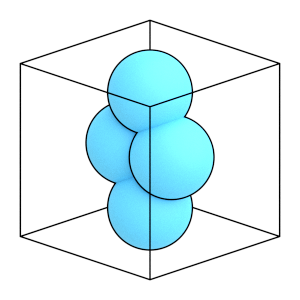

In [11]:
render_rigid_body(diagonal_positions)

The rigid body is now aligned to its principle rotational axes with the *x*, *y*, and *z* body
axes. Use `diagonal_positions`as body coordinates along with `I_diagonal` as the central particle's
`moment_inertia`.

To check, let's confirm that the directly calculated moment of inertia of the new coordinates is
diagonal.

In [12]:
I_check = numpy.zeros(shape=(3, 3))
for r in diagonal_positions:
    I_check += I_ref + particle_mass * (
        numpy.dot(r, r) * numpy.identity(3) - numpy.outer(r, r)
    )

I_check

array([[ 5.60000000e+00, -2.35513869e-16,  0.00000000e+00],
       [-2.35513869e-16,  2.60000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  6.60000000e+00]])

This moment of inertia is diagonal within numerical precision.

<div class="alert alert-info">
When the diagonalization process produces very small numerical values for the diagonal elements, set
them to 0 explicitly to disable those degrees of freedom. Otherwise, HOOMD-blue will attempt to 
integrate them, resulting in numerical instabilities.
</div>

This is the end of the introduction to the modeling rigid bodies tutorial! It described the
properties of rigid bodies, showed how to run a simulation of dimers, and demonstrated how to
diagonalize the moment of inertia of general bodies. See the other HOOMD-blue tutorials to learn
about other concepts, or browse the reference documentation for more information.